# [Issue 12](https://github.com/tgsmith61591/pyramid/issues/12)

The purpose of this notebook is to debug issue 12

Here is the Pyramid version info:

In [4]:
import pyramid
print("Pyramid version: %r" % pyramid.__version__)

Pyramid version: '0.5-dev4'


### Read the data in:

In [5]:
import pandas as pd

data = pd.read_csv('dummy_data.csv')
data.head()

,time,occupancy
0,2017-03-01 00:02:01,2
1,2017-03-01 00:04:01,3
2,2017-03-01 00:06:01,2
3,2017-03-01 00:08:01,1
4,2017-03-01 00:10:01,4


### Determining the periodicity

Our issue filer claims that the periodicity of the data is every 2 minutes:

> I have a seasonal time-series data set which comprises of 2 months of data. Now if I mention the frequency as "2 min" or "365x24x30" then it tries to divide the dataset with that frequency. But my data set is just for 2 months and obviously, it has way lesser values than the freq.

Therefore, rather than use `365 * 24 * 30 = 262800`, we can probably use the number of days in the two months (say, 60) instead of the 365: `60 * 24 * 30 = 43200`

In [10]:
n_days = 60
n_hours = 24
n_minutes = 30  # every other minute

# determine m:
m = n_days * n_hours * n_minutes
m

43200

However, `m` is greater than the number of samples in the data, which is suspect... *unless there is LOTS of data, it's unlikely we have a bi-minutely seasonal period...*

In [13]:
print("n_periods: %i" % m)
print("n_samples: %i" % data.shape[0])

n_periods: 43200
n_samples: 1610


On inspection of the data, it's clear that there is a 2 minute interval between each sample, __but what is the *actual* seasonality__? That's what we're unsure of. Let's take a look:

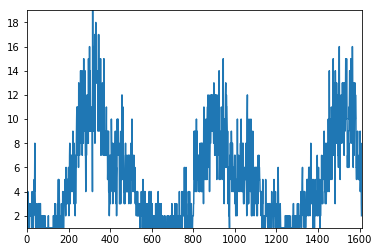

In [18]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# extract the data we're interested in
n_samples = data.shape[0]
xlab, y = data.time, data.occupancy

plt.plot(np.arange(n_samples), y)
plt.axis([0, n_samples, y.min(), y.max()])
plt.show()

__We can see that even though the data is separated at a 2-minute interval, the seasonality is VERY DIFFERENT (and much less frequent)__. Therefore, part of the issue is the assumption that the actual data frequency is equivalent to the seasonality. *It is not!!* It looks like we have 3 seasons in a 2 month period, which means we likely have 18 seasons over the course of the year (3 * 6).

This is really important to understand: the `m` parameter must be apriori knowledge!! Even R's `auto.arima` will have a tough time fitting a model for a `ts` with unknown frequency.